### EfficientNetv2
TOO slow to train

### Xception
Not good result, 60 max 70% (not tried to much)

### Resnet50 v2


In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import keras_cv as keras_cv

#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [14]:
#Create Instances Of Utils Helper
seed = 5000
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4', 4: 'Species5', 5: 'Species6', 6: 'Species7',
          7: 'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../", 5000)  #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper = ModelHelper("../../", labels)  #take in input local models folder and lables
model_helper.create_seed(tf, seed);

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [3]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
#X,Y = dataset_helper.load_Dataset(22)

dataset_size = X.shape[0]
print("Dataset Size" + str(dataset_size))

#SPLIT and NORMALIZE OUR DATASET
X_train, X_test, X_val, Y_train, Y_test, Y_val = dataset_helper.split_and_normalize(X, Y, split_test=0.1, split_val=0.1,
                                                                                    normalization_mode=1)

X_t_original = X_train
Y_t_original = Y_train

Dataset Size3542


In [4]:
#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 5000,
                                                                     disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1),
                                                                     seed=7654)


Data Augmentation with data distribution
Data distribution = [0.16675 0.11055 0.11315 0.11395 0.11075 0.16075 0.10975 0.11435]
Class Size :  151, generating: 833
787 images generated
Class Size :  432, generating: 552
528 images generated
Class Size :  419, generating: 565
515 images generated
Class Size :  415, generating: 569
543 images generated
Class Size :  431, generating: 553
527 images generated
Class Size :  181, generating: 803
756 images generated
Class Size :  436, generating: 548
532 images generated
Class Size :  413, generating: 571
541 images generated


In [5]:
X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.07)

Metal device set to: Apple M1 Pro


2022-11-23 18:37:18.575531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-23 18:37:18.575664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-23 18:37:19.067018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-23 18:37:21.346505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [6]:
import random

c = list(zip(X_train, Y_train))
random.shuffle(c)
X_train, Y_train = zip(*c)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [ ]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
classe = 2
filter_classes = False
for i in range(1, columns * rows + 1):
    if not (filter_classes) or np.argmax(Y_train[start + i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text('Label: ' + labels[np.argmax(Y_train[start + i])])
        plt.imshow((X_train[start + i] * 255).astype(np.uint8))
    else:
        i = i - 1
fig.tight_layout()
plt.show()


KeyboardInterrupt



# Define the model Structure
Create a function that declare all the model components

In [9]:
def stackDenseLayer(layer_name, last_layer, size=256, activation='relu', drop_out=False, drop_rate=0.5,
                    GlorthUniform=False, batch_normalization=False):
    initializer = tfk.initializers.HeUniform(seed)
    if GlorthUniform:
        initializer = tfk.initializers.GlorotUniform(seed)

    dense_layer = tfkl.Dense(
        units=size,
        name=layer_name,
        activation=activation,
        kernel_initializer=initializer  #Can Be HeUniform(seed) or GlorotUniform(seed)
    )(last_layer)

    #If desired, apply batch normalization
    if batch_normalization:
        dense_layer = tfkl.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=0.001,
            center=True,
            scale=True,
            beta_initializer="zeros",
            gamma_initializer="ones",
            moving_mean_initializer="zeros",
            moving_variance_initializer="ones"
        )(dense_layer)
    #If desired add droppout
    if drop_out:
        dense_layer = tfkl.Dropout(drop_rate, seed=seed)(dense_layer)

    return dense_layer



In [10]:
def stackConvolutionLayer(layer_name, last_layer, kernel_size=(3, 3), num_of_filter=32, strides=(1, 1),
                          activation='relu', padding='same', pooling_size=(2, 2), batch_normalization=False,
                          num_of_stacked_conv=1):
    layer_activation = activation

    for i in range(0, num_of_stacked_conv):
        curr_name = layer_name + "_conv" + str(i)

        if batch_normalization and i == num_of_stacked_conv - 1:
            activation = None

        curr_conv = tfkl.Conv2D(
            filters=num_of_filter,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            activation=layer_activation,
            name=curr_name,
            kernel_initializer=tfk.initializers.HeUniform(seed)
        )(last_layer)

        if batch_normalization and i == num_of_stacked_conv - 1:  #Batch  true and last conv in layer
            batch = BatchNormalization()(curr_conv)
            activation = tfkl.Activation(layer_activation)(batch)
            curr_conv = activation

        last_layer = curr_conv

        pool = tfkl.MaxPooling2D(pool_size=pooling_size)(last_layer)

    return pool

In [11]:
def fineTuning(keras_model, input_shape, input_layer, num_of_freezed_layers=0):
    base_model = keras_model(include_top=False, weights="imagenet", input_shape=input_shape)
    base_model.trainable = True

    for i, layer in enumerate(base_model.layers[:num_of_freezed_layers]):
        layer.trainable = False

    base_model = base_model(input_layer)

    return base_model

In [4]:
import keras.backend as K


def F1(y_true, y_pred):  #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [13]:
# Download and plot the VGG16 model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

X_train_ft = preprocess_input(X_train * 255)
X_val_ft = preprocess_input(X_val * 255)
X_test_ft = preprocess_input(X_test * 255)

supernet = tfk.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3)
)

supernet.summary()
tfk.utils.plot_model(supernet)

Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 24)   96          ['stem_conv[0][0]']              
                                                                                   

In [ ]:
#Create the Model
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Use the supernet as feature extractor
    supernet.trainable = False

    inputs = tfk.Input(shape=input_shape)
    #x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
    supernet_layer = supernet(inputs)

    flattening = tfkl.Flatten(name='Flattening')(supernet_layer)
    flattening = tfkl.Dropout(0.2, seed=seed)(flattening)
    #flattening = tfkl.GlobalAveragePooling2D(name='GlobalAVGPool')(supernet_layer)

    classifier_0 = stackDenseLayer("classifier_0", flattening, size=256, GlorthUniform=True, drop_out=True,
                                   drop_rate=0.2)
    #classifier_1 = stackDenseLayer("classifier_1",classifier_0,size=128,GlorthUniform=True,drop_out=True,drop_rate=0.2)
    #classifier_2 = stackDenseLayer("classifier_2",classifier_1,size=64,GlorthUniform=True,drop_out=True,drop_rate=0.2)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                              name='Output')(classifier_0)

    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='Xception')

    # Compile the model
    tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(),
                     metrics=['accuracy', F1])
    return tl_model

# Training Phase
Compile the model, configure all necessary infomation for training like epoch,batches, callbacks...
Then start the training

### Compile the model

In [ ]:
#Build the model
input_shape = X_train.shape[1:]  #(None,96,96,3)
batch_size = 128
epochs = 100

model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

### Train the model

In [16]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True,
                                                  where_to_save="./local_checkpoints", patience=15,
                                                  model_name="Efficent_net_v2B-Base")

#Fit the model
history = model.fit(
    x=X_train_ft,
    y=Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_ft, Y_val),
    callbacks=callbacks_selected
).history

Epoch 1/100


2022-11-22 12:17:41.837582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


253/253 [==============================] - ETA: 0s - loss: 1.5817 - accuracy: 0.4420 - F1: 0.3020

2022-11-22 12:19:39.901330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


253/253 [==============================] - 143s 482ms/step - loss: 1.5817 - accuracy: 0.4420 - F1: 0.3020 - val_loss: 1.0603 - val_accuracy: 0.6289 - val_F1: 0.5505
Epoch 2/100
253/253 [==============================] - 105s 415ms/step - loss: 1.2696 - accuracy: 0.5464 - F1: 0.4641 - val_loss: 0.9635 - val_accuracy: 0.6635 - val_F1: 0.6113
Epoch 3/100
253/253 [==============================] - 105s 413ms/step - loss: 1.2025 - accuracy: 0.5753 - F1: 0.5093 - val_loss: 0.9054 - val_accuracy: 0.7044 - val_F1: 0.6519
Epoch 4/100
253/253 [==============================] - 108s 426ms/step - loss: 1.1537 - accuracy: 0.5961 - F1: 0.5355 - val_loss: 0.8930 - val_accuracy: 0.6950 - val_F1: 0.6709
Epoch 5/100
253/253 [==============================] - 99s 391ms/step - loss: 1.1242 - accuracy: 0.6051 - F1: 0.5507 - val_loss: 0.9062 - val_accuracy: 0.6824 - val_F1: 0.6475
Epoch 6/100
253/253 [==============================] - 103s 409ms/step - loss: 1.0908 - accuracy: 0.6186 - F1: 0.5710 - val_loss

In [21]:
model_helper.save_model(model, "EfficientNetV2M-Base")

INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-Base/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-Base/assets


12/12 [==============================] - 2s 149ms/step
Accuracy: 0.7571
Precision: 0.7376
Recall: 0.7139
F1: 0.7139


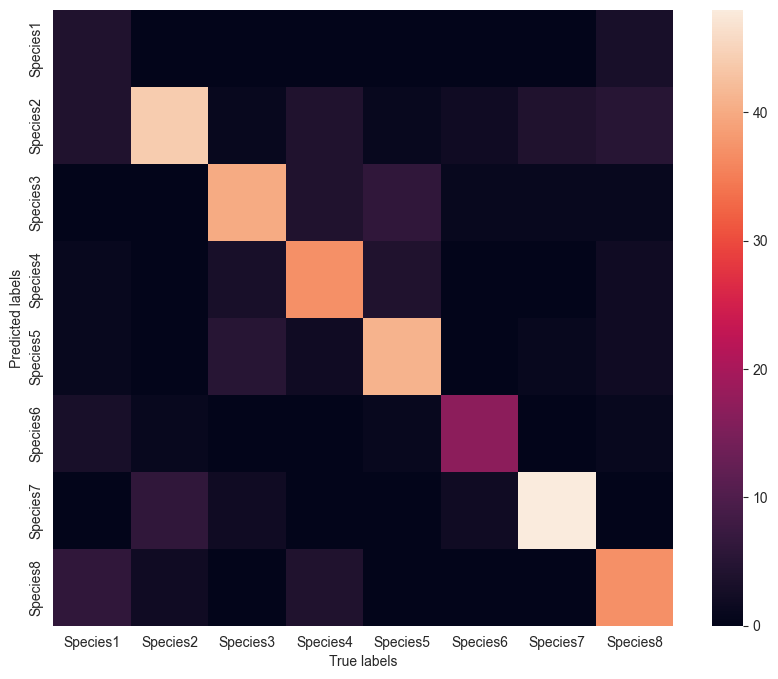

BABABA


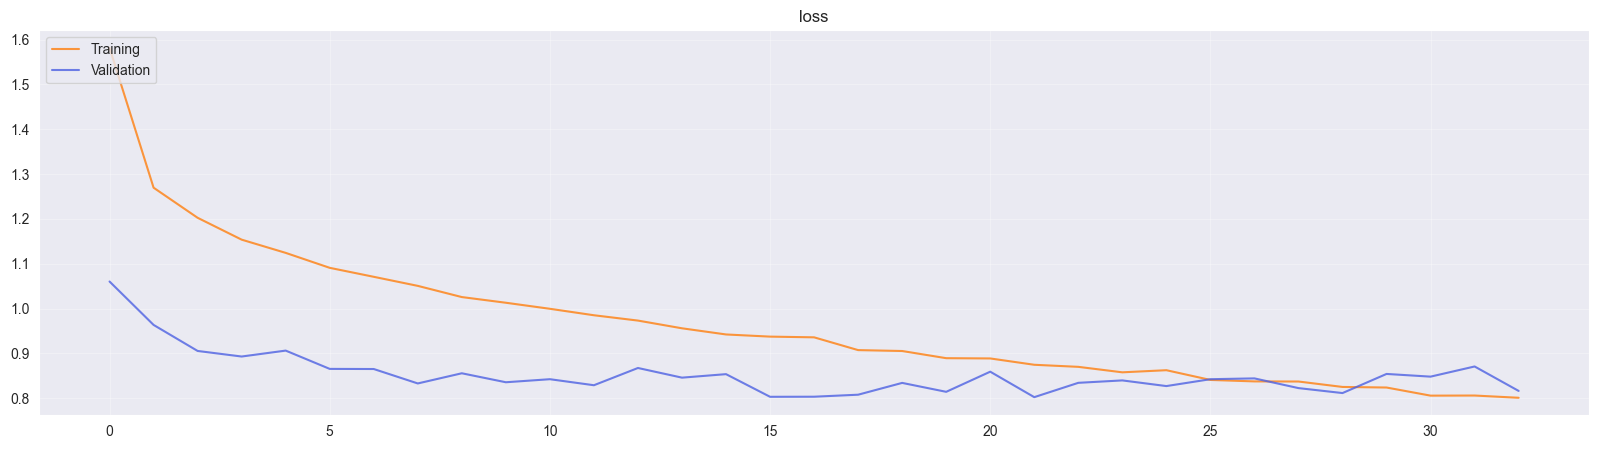

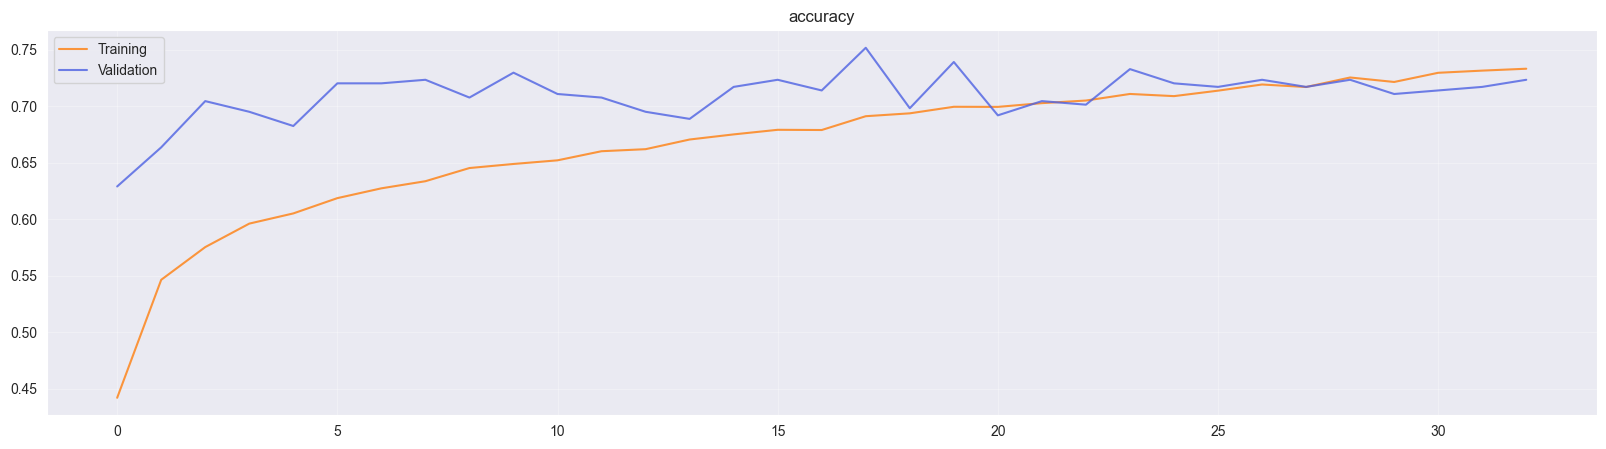

In [22]:
model_helper.show_confusion_matrix(X_test_ft, Y_test)
model_helper.plot_phase_train_vs_validation(history)

# Step 2 -> Fine tuning 100 layer freezed

In [8]:
ft_model = tf.keras.models.load_model("../../local_saved_models/EfficientNetV2M-ft-1-layers",custom_objects = {"F1":F1})
ft_model.summary()
# Loads the weights

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 3, 3, 1280)       53150388  
 l)                                                              
                                                                 
 Flattening (Flatten)        (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 classifier_0 (Dense)        (None, 256)               2949376   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                          

In [10]:
# Download and plot the VGG16 model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

X_train_ft = preprocess_input(X_train * 255)
X_val_ft = preprocess_input(X_val * 255)
X_test_ft = preprocess_input(X_test * 255)


In [11]:

# Re-evaluate the model
loss, acc, f1 = ft_model.evaluate(X_test_ft, Y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2022-11-23 18:39:30.843697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 - 7s - loss: 0.9621 - accuracy: 0.8277 - F1: 0.8037 - 7s/epoch - 614ms/step
Restored model, accuracy: 82.77%


In [12]:
num_of_freezed_layer = 1
# Freeze first N layers, e.g., until 14th
ft_model.get_layer('efficientnetv2-m').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers[:num_of_freezed_layer]):
    layer.trainable = False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block1c_project_conv True
15 block1c_project_bn True
16 block1c_project_activation True
17 block1c_drop True
18 block1c_add True
19 block2a_expand_conv True
20 block2a_expand_bn True
21 block2a_expand_activation True
22 block2a_project_conv True
23 block2a_project_bn True
24 block2b_expand_conv True
25 block2b_expand_bn True
26 block2b_expand_activation True
27 block2b_project_conv True
28 block2b_project_bn True
29 block2b_drop True
30 block2b_add True
31 block2c_expand_conv True
32 block2c_expand_bn True
33 block2c_expand_activation True
34 block2c_project_conv True
35 block2c_project_bn True
36 block2c_drop True
37 block2c_add True
38 block2d_expand_conv True


In [13]:
# Compile the model
model_name = "EfficientNetV2M-ft-" + str(num_of_freezed_layer) + "-layers"
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4),
                 metrics=['accuracy', F1])

In [14]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, tensorboard=True,
                                                  where_to_save="local_checkpoints", patience=30, model_name=model_name)

#Build the model
input_shape = X_train.shape[1:]  #(None,96,96,3)
batch_size = 128
epochs = 200

#Fit the model
history = ft_model.fit(
    x=X_train_ft,
    y=Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_ft, Y_val),
    callbacks=callbacks_selected
).history

Epoch 1/200


2022-11-23 18:39:57.322896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 1.0316 - accuracy: 0.6680 - F1: 0.6394

2022-11-23 18:42:25.472463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 184s 2s/step - loss: 1.0316 - accuracy: 0.6680 - F1: 0.6394 - val_loss: 0.4804 - val_accuracy: 0.8270 - val_F1: 0.8412
Epoch 2/200
78/78 [==============================] - 103s 1s/step - loss: 0.5699 - accuracy: 0.8190 - F1: 0.8149 - val_loss: 0.4394 - val_accuracy: 0.8585 - val_F1: 0.8657
Epoch 3/200
78/78 [==============================] - 104s 1s/step - loss: 0.3626 - accuracy: 0.8966 - F1: 0.8881 - val_loss: 0.4672 - val_accuracy: 0.8491 - val_F1: 0.8570
Epoch 4/200
78/78 [==============================] - 102s 1s/step - loss: 0.2438 - accuracy: 0.9402 - F1: 0.9277 - val_loss: 0.5376 - val_accuracy: 0.8459 - val_F1: 0.8534
Epoch 5/200
78/78 [==============================] - 102s 1s/step - loss: 0.1979 - accuracy: 0.9536 - F1: 0.9388 - val_loss: 0.5383 - val_accuracy: 0.8522 - val_F1: 0.8576
Epoch 6/200
78/78 [==============================] - 97s 1s/step - loss: 0.1769 - accuracy: 0.9545 - F1: 0.9412 - val_loss: 0.5923 - val_accuracy: 0.858

In [15]:
model_helper.save_model(ft_model, model_name)

INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-ft-1-layers/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-ft-1-layers/assets


2022-11-23 22:34:01.407400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 21s 1s/step
Accuracy: 0.839
Precision: 0.8195
Recall: 0.7857
F1: 0.7965


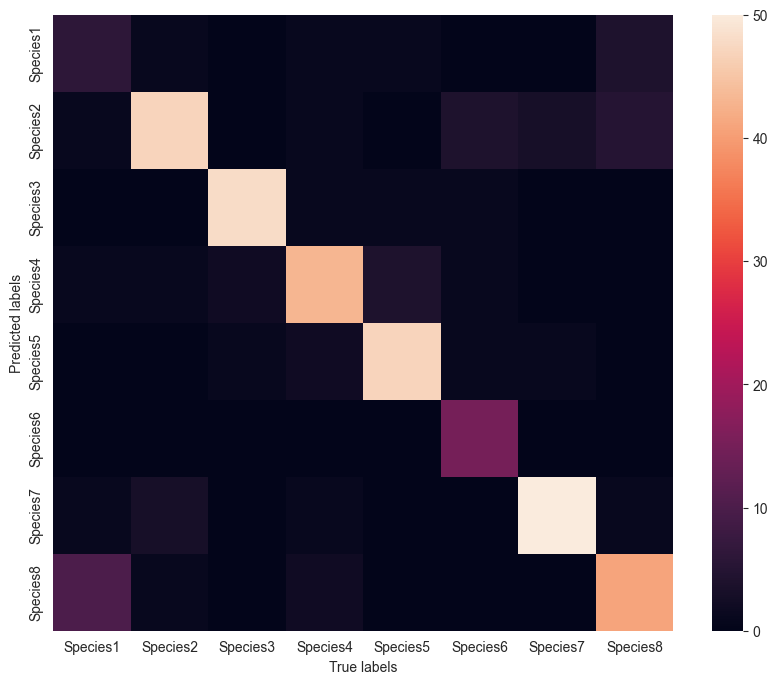

BABABA


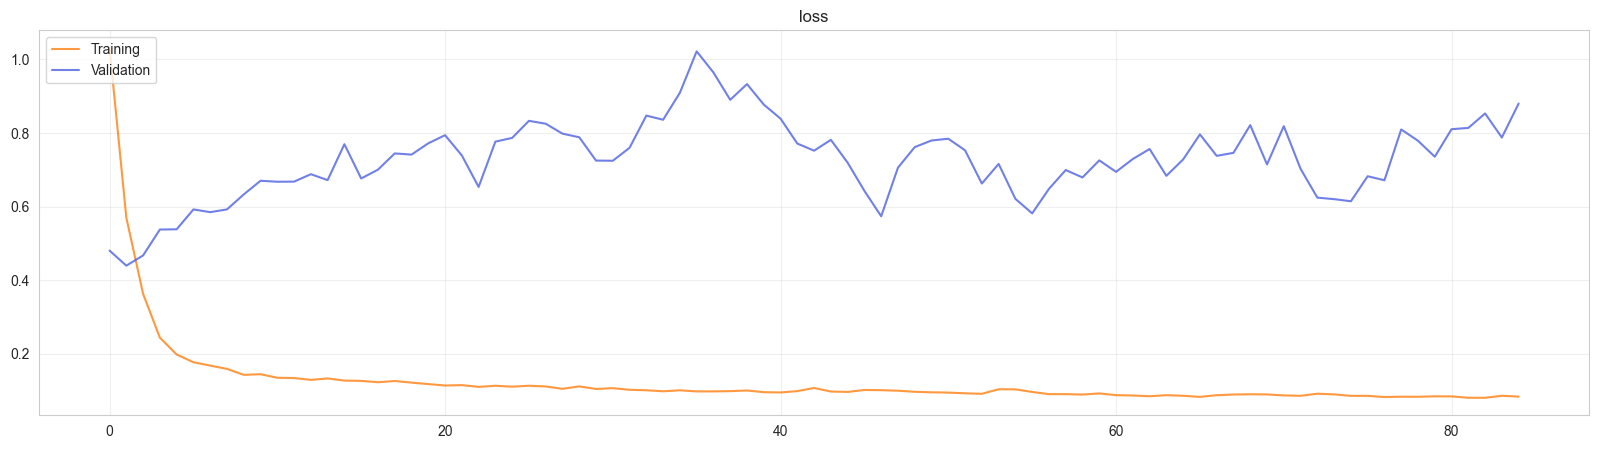

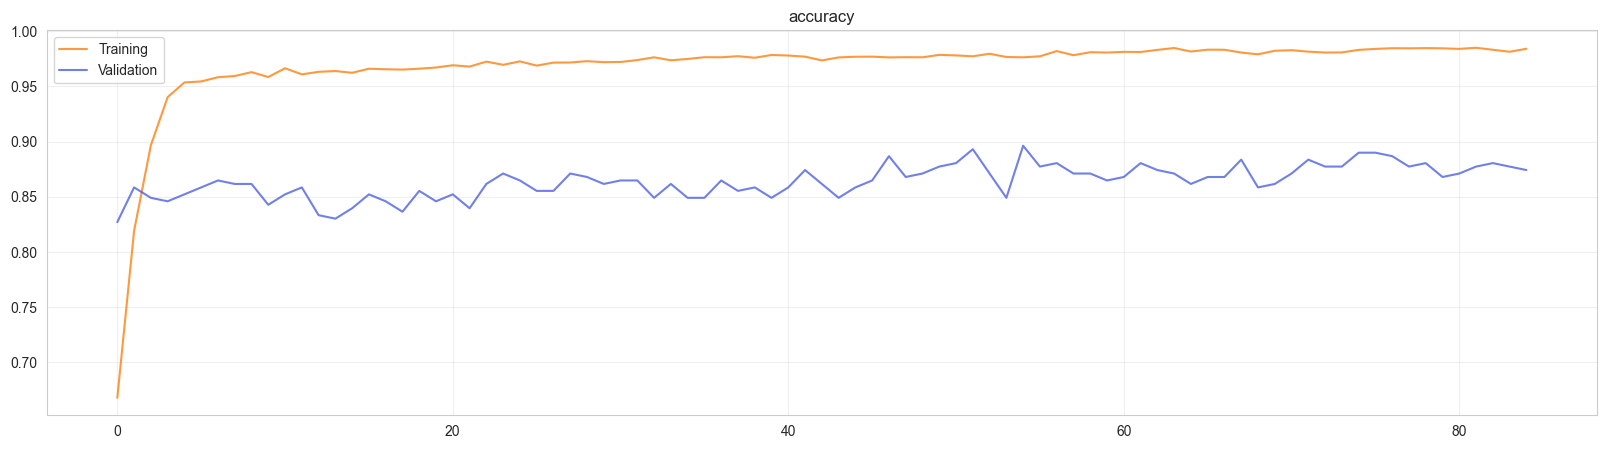

ciao


In [16]:
model_helper.show_confusion_matrix(X_test_ft, Y_test)
model_helper.plot_phase_train_vs_validation(history)
print("ciao")

# STEP 3 -> Change augmentation seed and train some other epoche with 150 freezed layer

In [5]:
ft_model = tf.keras.models.load_model("../../local_saved_models/EfficientNetV2M-ft-100-layers",
                                      custom_objects={"F1": F1})
ft_model.summary()

Metal device set to: Apple M1 Pro


2022-11-28 18:30:35.720889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 18:30:35.721005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 3, 3, 1280)       53150388  
 l)                                                              
                                                                 
 Flattening (Flatten)        (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 classifier_0 (Dense)        (None, 256)               2949376   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                          

In [7]:
#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 15000,
                                                                     disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1),
                                                                     seed=8759)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.25)



import random

c = list(zip(X_train, Y_train))
random.shuffle(c)
X_train, Y_train = zip(*c)
X_train = np.array(X_train)
Y_train = np.array(Y_train)




Data Augmentation with data distribution
Data distribution = [0.145875 0.117775 0.119075 0.119475 0.117875 0.142875 0.117375 0.119675]
Class Size :  151, generating: 1458
1359 images generated
Class Size :  432, generating: 1177
1120 images generated
Class Size :  419, generating: 1190
1126 images generated
Class Size :  415, generating: 1194
1182 images generated
Class Size :  431, generating: 1178
1118 images generated
Class Size :  181, generating: 1428
1331 images generated
Class Size :  436, generating: 1173
1128 images generated
Class Size :  413, generating: 1196
1178 images generated


2022-11-22 19:35:13.118788: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

X_train_ft = preprocess_input(X_train * 255)
X_val_ft = preprocess_input(X_val * 255)
X_test_ft = preprocess_input(X_test * 255)


In [10]:
num_of_freezed_layer = 1

In [9]:

# Freeze first N layers, e.g., until 14th
ft_model.get_layer('efficientnetv2-m').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers[:num_of_freezed_layer]):
    layer.trainable = False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block1c_project_conv True
15 block1c_project_bn True
16 block1c_project_activation True
17 block1c_drop True
18 block1c_add True
19 block2a_expand_conv True
20 block2a_expand_bn True
21 block2a_expand_activation True
22 block2a_project_conv True
23 block2a_project_bn True
24 block2b_expand_conv True
25 block2b_expand_bn True
26 block2b_expand_activation True
27 block2b_project_conv True
28 block2b_project_bn True
29 block2b_drop True
30 block2b_add True
31 block2c_expand_conv True
32 block2c_expand_bn True
33 block2c_expand_activation True
34 block2c_project_conv True
35 block2c_project_bn True
36 block2c_drop True
37 block2c_add True
38 block2d_expand_conv True


In [11]:
# Compile the model
model_name = "EfficientNetV2M-ft-" + str(num_of_freezed_layer) + "-layers-Step3"

In [10]:

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4),
                 metrics=['accuracy', F1])
model_helper.save_model(ft_model, model_name)

INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-ft-1-layers-Step3/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-ft-1-layers-Step3/assets


In [11]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, tensorboard=True, patience=20,
                                                  model_name=model_name)

#Build the model
input_shape = X_train.shape[1:]  #(None,96,96,3)
batch_size = 128
epochs = 100

#Fit the model
history = ft_model.fit(
    x=X_train_ft,
    y=Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_ft, Y_val),
    callbacks=callbacks_selected
).history

Epoch 1/30


2022-11-22 19:39:09.574497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.9087 - F1: 0.9129

2022-11-22 19:45:17.674426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


237/237 [==============================] - 408s 2s/step - loss: 0.2827 - accuracy: 0.9087 - F1: 0.9129 - val_loss: 0.5426 - val_accuracy: 0.8616 - val_F1: 0.8729
Epoch 2/30
237/237 [==============================] - 335s 1s/step - loss: 0.0744 - accuracy: 0.9742 - F1: 0.9774 - val_loss: 0.6534 - val_accuracy: 0.8711 - val_F1: 0.8738
Epoch 3/30
237/237 [==============================] - 334s 1s/step - loss: 0.0660 - accuracy: 0.9765 - F1: 0.9791 - val_loss: 0.6367 - val_accuracy: 0.8648 - val_F1: 0.8734
Epoch 4/30
237/237 [==============================] - 342s 1s/step - loss: 0.0588 - accuracy: 0.9787 - F1: 0.9804 - val_loss: 0.6148 - val_accuracy: 0.8711 - val_F1: 0.8735
Epoch 5/30
237/237 [==============================] - 331s 1s/step - loss: 0.0556 - accuracy: 0.9804 - F1: 0.9821 - val_loss: 0.5858 - val_accuracy: 0.8836 - val_F1: 0.8948
Epoch 6/30
237/237 [==============================] - 331s 1s/step - loss: 0.0509 - accuracy: 0.9812 - F1: 0.9828 - val_loss: 0.6564 - val_accurac

In [12]:
#model_name = model_name+"-step3"
model_helper.save_model(ft_model, model_name)

INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-ft-1-layers-Step3/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/EfficientNetV2M-ft-1-layers-Step3/assets


Set Model to Model Helper


2022-11-28 18:37:09.348230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 6s 348ms/step
Accuracy: 0.9746
Precision: 0.979
Recall: 0.9574
F1: 0.9656


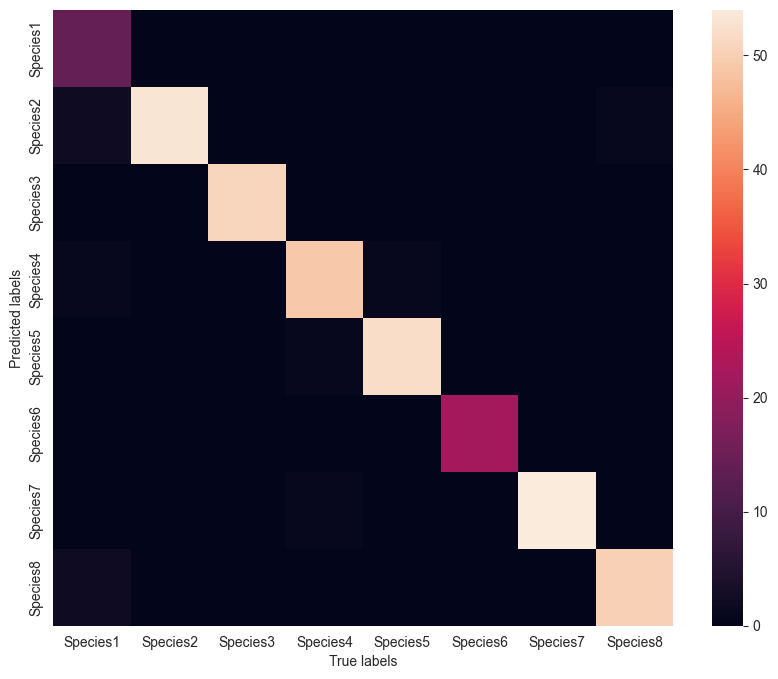

In [16]:
model_helper.show_confusion_matrix(X_test_ft, Y_test, model=ft_model)

2022-11-28 18:34:49.427600: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-28 18:34:50.843231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 7s 300ms/step
Accuracy: 0.9746
Precision: 0.979
Recall: 0.9574
F1: 0.9656


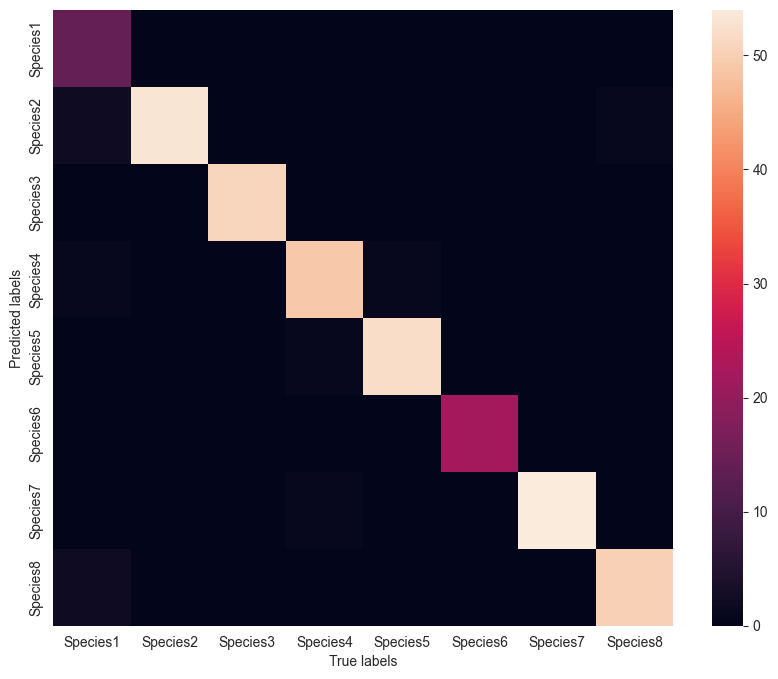

NameError: name 'history' is not defined

In [13]:

model_helper.plot_phase_train_vs_validation(history)

# CONVERSION OF MODEL FROM 2.11 to 2.9.2

In [8]:
#ft_model = model_helper.load_model("Xception_Freezed_CNN_AvgPooling3Dense",)
# Compile the model
num_of_freezed_layer = 100
model_name = "EfficientNetV2M-ft-" + str(num_of_freezed_layer) + "-layers"
ft_model = tf.keras.models.load_model("local_saved_models/" + model_name, custom_objects={"F1": F1})
ft_model.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 3, 3, 1280)       53150388  
 l)                                                              
                                                                 
 Flattening (Flatten)        (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 classifier_0 (Dense)        (None, 256)               2949376   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                          

In [9]:
# Download and plot the VGG16 model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

X_train_ft = preprocess_input(X_train * 255)
X_val_ft = preprocess_input(X_val * 255)
X_test_ft = preprocess_input(X_test * 255)

12/12 [==============================] - 8s 109ms/step
Accuracy: 0.8192
Precision: 0.8031
Recall: 0.8012
F1: 0.7969


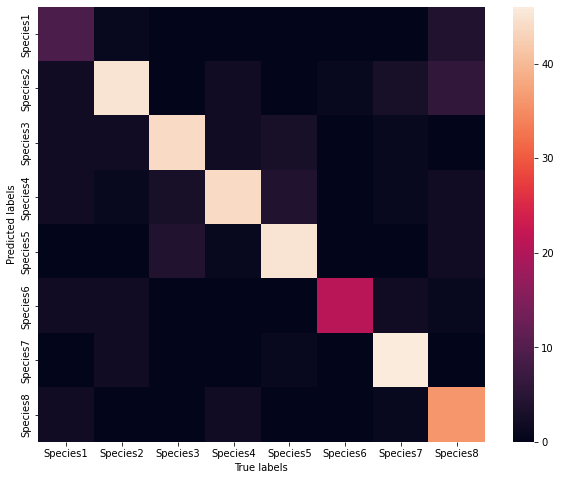

In [10]:
model_helper.show_confusion_matrix(X_test_ft, Y_test, model=ft_model)

In [11]:
ft_model.save_weights("salvataggio")

In [19]:
# Loads the weights
#Xception-ft-1-layers_Nov19_14-52-47
model.load_weights("./salvataggio")

# Re-evaluate the model
loss, acc, f1 = model.evaluate(X_test_ft, Y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

12/12 - 11s - loss: 0.8534 - accuracy: 0.8192 - F1: 0.8303 - 11s/epoch - 948ms/step
Restored model, accuracy: 81.92%


12/12 [==============================] - 5s 67ms/step
Accuracy: 0.8192
Precision: 0.8031
Recall: 0.8012
F1: 0.7969


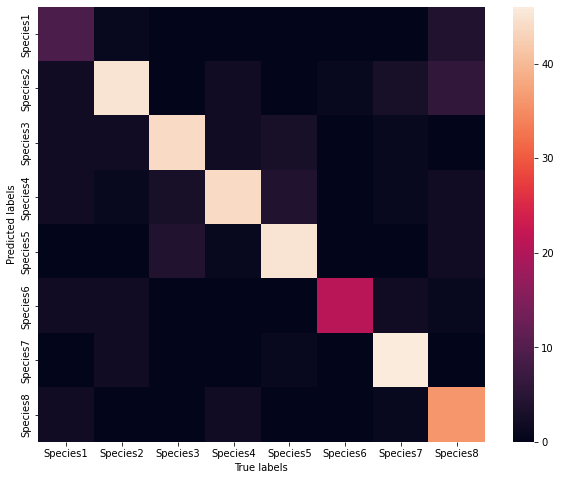

In [21]:
model_helper.show_confusion_matrix(X_test_ft, Y_test, model=model)

In [15]:
!pip install tensorflow == 2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.8 MB 7.2 kB/s 
     |████████████████████████████████| 1.6 MB 39.1 MB/s 
     |████████████████████████████████| 5.8 MB 54.0 MB/s 
     |████████████████████████████████| 438 kB 46.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.0
    Uninstalling tensorboard-2.11.0:
      Successfully uninstalled tensorboard-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 22.10.26
    Uninstalling flatbuffers-22.10.26:
  

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
!pip install visualkeras
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
% load_ext autoreload
% autoreload 2

[autoreload of tensorflow.python failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/__init__.py", line 121, in <module>
    '/tensorflow/api/tf2_enable', 'Environment variable TF2_BEHAVIOR is set".')
  File "/usr/local/lib/python3.7/dist-packages/tenso